In [100]:
import matplotlib.pyplot as plt
import numpy as np

from utility import *

from scipy.fft import fft, ifft, fftfreq, fftshift
import scipy.signal

from tensorforce.environments import Environment
from tensorforce.agents import Agent

# Radar Environment Setup

In [101]:
# implement the radar environment
class RadarEnvironment(Environment):
    def __init__(self, basis_freqs):
        """[summary]

        Args:
            basis_freqs ([type] Nx1 numpy array): [description] contains N basis angular freqs
            max_timesteps ([type] int ): [description] the maximum number of timesteps per episode
        """

        # define environment hyperparameters (in this case, the hyperparameters are the radar waveform set parameterization)
        self.basis_freqs = basis_freqs
        self.N = self.basis_freqs.size
        self.band_width = np.max(self.basis_freqs) - np.min(self.basis_freqs)
        self.Fs = 2 * self.band_width  # sampling frequency for the radar waveform
        # duration is two periods of the exponential with the smallest freq
        self.duration = (0, 2 * 1.0 / np.min(np.abs(self.basis_freqs)))

        # envrionment parameters used to compute reward
        
        self.current_best_PSL = 0
        

        super().__init__()


    def states(self):
        return dict(type='float', shape=(self.N, 1), min_value=-1.0, max_value=1.0)

    # Q: does action have to be discrete??
    def actions(self):
        # 0: -0.1, 1: 0, 2: 0.1
        return dict(type='int', shape=(self.N, 1), num_values =3)

    def action_map(self, actions):
        """[summary] 0: -0.1, 1: 0, 2: 0.1
            e.g. 

            actions repr used by agent: [0 1 2 1 1].T --> actions repr used by the environment [-0.1 0 0.1 0 0].T

        Args:
            actions ([type]): [description] the actions repr used by the agent

        Returns:
            [type]: [description] the actions repr used by the environment
        """
        return -0.1 + 0.1 * actions

    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    def close(self):
        super().close()

    def reset(self):
        """[summary] reset() is for reset the environment at the beginning of each episode

        Returns:
            [type]: [description]
        """
        self.timestep = 0
        self.current_state = np.random.uniform(
            low=-1.0, high=1.0, size=(self.N, 1))

        
        self.current_best_state = self.current_state
        self.current_best_PSL = self.compute_PSL(self.current_state)
        

        return self.current_state

    #####################################################################
    # Utility functions for computing waveform parameters
    #####################################################################

    @staticmethod
    def freqD_to_timeD(state, duration, basis_freqs, Fs):
        """[summary] convert the waveform parameters to its time domain representation

        Args:
            state ([type]): [description] a column vector (2D np array with shape (N, 1))
            duration ([type] a tuple (start_time, end_time)): [description]
            basis_freqs ([type] column vector): [description]
            BW ([type] scalar): [description]
            Fs ([type] scalar): [description]

        Returns:
            [type]: [description] p_b is a row vector, a row vector is a 2-D np array with shape(1, N)
        """

        w = 2*np.pi*basis_freqs

        a = state.T
        t = np.arange(duration[0], duration[1], 1.0/Fs).reshape((1, -1))

        A = w @ t

        p_b = a @ np.exp(1j * A)  # here p_b is a row vector

        return p_b

    @staticmethod
    def point_spread_fn(p_b, Fs):
        """[summary] assume p_b is a row vector. 
            convert the p_b, a time domain repr of the baseband signal, into its point spread function, 
            a complex-valued function

        Args:
            p_b ([type]): [description] a row vector
            Fs ([type]): [description] sampling frequency

        Returns:
            [type]: [description] (t, psf): all row vectors
        """
        (freqs, spectrum) = fourier_spectrum(p_b, Fs)
        psd = np.abs(spectrum) ** 2
        psf = fftshift(ifft(psd))

        N = psf.size
        t = np.linspace(0, N * 1.0 / Fs, N).reshape((1, -1))
        return t, psf

    
    @staticmethod
    def peak_sidelobe_level(psf):
        """[summary]

        Args:
            psf ([type] row vector): [description] row vector with shape (1, N)

        Returns:
            [type]: [description] peak sidelobe level, which is a positive real number.
                    and 0 means the worst, +inf means the best.
        """
        psf_abs = np.abs(psf)
        psf_abs_sorted = np.sort(psf_abs)

        PSL = 20 * np.log10(psf_abs_sorted[0, -1] / psf_abs_sorted[0, -2])
        return PSL


    @staticmethod
    def main_lobe_width(state):
        pass
    


    ############################################
    # Utility functions
    ##############################################

    def compute_PSL(self, state):
        p_b = RadarEnvironment.freqD_to_timeD(
            state, self.duration, self.basis_freqs, self.Fs)
        (t, psf) = RadarEnvironment.point_spread_fn(p_b, self.Fs)
        PSL = RadarEnvironment.peak_sidelobe_level(
            psf)  # recall it is always a positive
        return PSL

    def plot_psf_abs(self, state):

        p_b = RadarEnvironment.freqD_to_timeD(
            state, self.duration, self.basis_freqs, self.Fs)
        (t, psf) = RadarEnvironment.point_spread_fn(p_b, self.Fs)

        plt.plot(t[0], np.abs(psf[0]))
        plt.title(f'positive PSL is {self.compute_PSL(state)}')
        plt.show()

    ################################################################
    # methods that defines the environment dynamics
    ###################################################################

    # define helper functions used by execute()
    def state_transition(self, actions):
        """[summary]

        Args:
            actions ([type]): [description] At, action repr used by the agent

        Returns:
            [type]: [description] S_(t+1), the next_state of the environment
        """
        actions = self.action_map(
            actions)  # convert action repr used by agent to action repr used by envrionment
        next_state = self.current_state + actions

        # make sure the states values are within range
        next_state[next_state > 1] = 1.0
        next_state[next_state < -1] = -1.0

        return next_state

    

    def compute_reward(self, state):
        """[summary] Compute the reward associated with the inpute state

        Args:
            state ([type]): [description]
        """
        
        PSL = self.compute_PSL(state)  # recall it is always a negative scalar

        reward = PSL - self.current_best_PSL
        return reward, PSL

    

    def dynamics_fn(self, actions):
        """The dynamics_fn is a blackbox whose input is current_state and action, 
        In this implementation, the current_state is contained in "self", thus, we don't 
        explicitly inlude current_state as input.

        Args:
            actions ([type] N by 1 integer arrays): [description] action repr used by the agent

        Returns:
            (next_state, reward)
        """

        # define helper functions for computing reward: recall the reward R_(t+1) is due to A_t and S_t,
        # thus R_(t + 1) is associated with the reward for state S_(t + 1)

        next_state = self.state_transition(actions)
        reward, PSL = self.compute_reward(next_state)

        return next_state, reward, PSL

    def execute(self, actions):

        # increment timestep
        self.timestep += 1

        # update the current_state
        self.current_state, self.reward, PSL = self.dynamics_fn(actions)

        # update current_best_PSL

        if PSL > self.current_best_PSL:
            self.current_best_state = self.current_state
            self.current_best_PSL = PSL

        terminal = False

        return self.current_state, terminal, self.reward


In [102]:
# test area
N = 10
max_episode_length = 100
basis_freqs_200 = np.linspace(start=-500e6, stop=500e6, num=200).reshape((-1, 1)) # notice the basis freq is assumed to be a column vector in this implementation


## Creation of the environment via Environment.create() creates
## a wrapper class around the original Environment defined here.
## That wrapper mainly keeps track of the number of timesteps.
## Environment.create() returns an instance of the wrapped version of your original environment class.

radar_env = Environment.create(environment=RadarEnvironment,
                               max_episode_timesteps=max_episode_length, basis_freqs=basis_freqs_100)


# Agent Setup

## Here we configure a type of agent to learn against this environment. There are many agent configurations to choose from, which we will not cover here. We will not discuss what type of agent to choose here -- we will just take a basic agent to train.

In [103]:
# check the tensorforce agent specs: https://tensorforce.readthedocs.io/en/latest/agents/tensorforce.html
# it includes the discount factor

agent = Agent.create(
    agent='tensorforce', environment=radar_env, update=64,
    optimizer=dict(optimizer='adam', learning_rate=1e-3),
    objective='policy_gradient', reward_estimation=dict(horizon=1)
)


# Check: Untrained Agent Performance
## The agent just initializes a policy and use that policy 

In [104]:
# Initialize
states = radar_env.reset()

internals = agent.initial_internals()
terminal = False


# Run an episode
negative_PSL = []
while not terminal:
    # ask the agent for an actions
    actions, internals = agent.act(states = states, internals = internals, independent=True)

    # apply the actions to the environment
    states, terminal, reward = radar_env.execute(actions=actions)

    # store the reward value
    negative_PSL.append(reward)

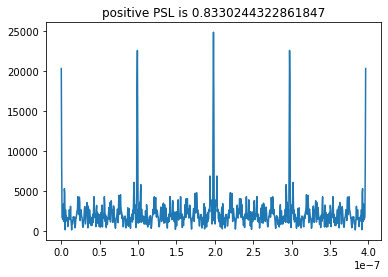

In [105]:
radar_env.plot_psf_abs(radar_env.current_best_state)

# Train the agent

In [106]:
# Train for 200 episodes

# collect best state in each episode
best_state_list = []
best_PSL_list = []

for episode_i in range(200):
    print(f"running episode {episode_i}")
    states = radar_env.reset()
    terminal = False
    while not terminal:
        actions = agent.act(states=states)
        states, terminal, reward = radar_env.execute(actions=actions)
        agent.observe(terminal=terminal, reward=reward)

    best_state_list.append(radar_env.current_best_state)
    best_PSL_list.append(radar_env.current_best_PSL)

running 0
running 1
running 2
running 3
running 4
running 5
running 6
running 7
running 8
running 9
running 10
running 11
running 12
running 13
running 14
running 15
running 16
running 17
running 18
running 19
running 20
running 21
running 22
running 23
running 24
running 25
running 26
running 27
running 28
running 29
running 30
running 31
running 32
running 33
running 34
running 35
running 36
running 37
running 38
running 39
running 40
running 41
running 42
running 43
running 44
running 45
running 46
running 47
running 48
running 49
running 50
running 51
running 52
running 53
running 54
running 55
running 56
running 57
running 58
running 59
running 60
running 61
running 62
running 63
running 64
running 65
running 66
running 67
running 68
running 69
running 70
running 71
running 72
running 73
running 74
running 75
running 76
running 77
running 78
running 79
running 80
running 81
running 82
running 83
running 84
running 85
running 86
running 87
running 88
running 89
running 90
running 9

In [107]:
radar_env.basis_freqs

array([[-5.00000000e+08],
       [-4.89898990e+08],
       [-4.79797980e+08],
       [-4.69696970e+08],
       [-4.59595960e+08],
       [-4.49494949e+08],
       [-4.39393939e+08],
       [-4.29292929e+08],
       [-4.19191919e+08],
       [-4.09090909e+08],
       [-3.98989899e+08],
       [-3.88888889e+08],
       [-3.78787879e+08],
       [-3.68686869e+08],
       [-3.58585859e+08],
       [-3.48484848e+08],
       [-3.38383838e+08],
       [-3.28282828e+08],
       [-3.18181818e+08],
       [-3.08080808e+08],
       [-2.97979798e+08],
       [-2.87878788e+08],
       [-2.77777778e+08],
       [-2.67676768e+08],
       [-2.57575758e+08],
       [-2.47474747e+08],
       [-2.37373737e+08],
       [-2.27272727e+08],
       [-2.17171717e+08],
       [-2.07070707e+08],
       [-1.96969697e+08],
       [-1.86868687e+08],
       [-1.76767677e+08],
       [-1.66666667e+08],
       [-1.56565657e+08],
       [-1.46464646e+08],
       [-1.36363636e+08],
       [-1.26262626e+08],
       [-1.1

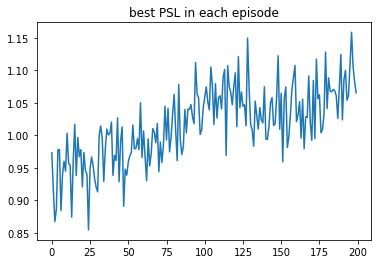

In [108]:
plt.plot(best_PSL_list)
plt.title("best PSL in each episode")
plt.show()

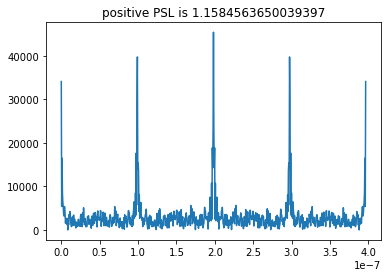

In [109]:
radar_env.plot_psf_abs(best_state_list[np.argmax(best_PSL_list)])

2000000000.0

# Trained Agent Performance